# Evaluation exercises

Ensure that you document your code with brief explanations for each step. Use markdown cells for any comments or clarifications on your thought process and any observations made during the analysis.

# Libraries

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from os import path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# To ignore some plot warnings
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


# Exercise 1: Dimensionality Reduction and Clustering

Load the Iris dataset and perform the following steps:

1. Apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset into 2D. Make sure to project your data in 2D with the three types of flowers labeled (with colours,...). How much variation is explained by the two principal components?

Load and explore data.

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
df['species'] = iris['target']
display(df.head())
display(df.describe())
display(df.isnull().sum()) # no missing values

Now we process the data for machine learning.

In [ ]:
# Continous independent variables
X = df.drop(['species'], axis=1)
# Labels or dependent variable (discrete classes)
Y = df['species']

# Scaling )
sc = StandardScaler() # substracts mean and divides by std
X_scaled = sc.fit_transform(X)

# Visualize first five rows 
X_scaled[:5]

In [ ]:
# Instanciate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to our model 
PC = pca.fit_transform(X_scaled)
print("Explained Variance Ratios:", pca.explained_variance_ratio_)  
print("\n")

# Visualize first five rows
print(PC[:5])

# Create a DataFrame with the t-SNE results
PC_df = pd.DataFrame(PC, columns=['PC1', 'PC2'])
print(PC_df)

We can see that 73% of the variance is explained with the 1st component and 23% with the second one, so 96% cumulatively which is good. Now we plot the components.

In [ ]:
plt.figure(figsize=(8, 6))
for i, target_name in enumerate(df['species'].unique()):
    plt.scatter(PC[df['species'] == i, 0], PC[df['species'] == i, 1], label=iris.target_names[i])

plt.title('PCA Projection of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


We can see that the first component separates well setosa from the 2 others, and with the second component added we can separate better the 3 kinds of petals. 

2. Use k-means clustering on the PCA-transformed data and try to extract some clusters. How does the random_seed influence on the results?


3. Compute the Silhouette Score and Adjusted Rand Index (ARI) for the k-means clustering, considering the known labels of the three types of flowers in the Iris dataset.

In [ ]:
# Function to calculate and plot k-means clustering
def kmeans_clustering_and_tsne(PC, true_labels, num_clusters_list, random_seed=42):

    all_clusters = list()
    for num_clusters in num_clusters_list:
        
        # Apply k-means clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed, n_init='auto')
        clusters = kmeans.fit_predict(PC)
        all_clusters.append(clusters)
    
        # Plot the t-SNE results with cluster colors
        plt.figure(figsize=(10, 8))
        plt.scatter(PC_df['PC1'], PC_df['PC2'], c=clusters, cmap='tab20', s=5)
        plt.title(f'PC Visualization (Clusters={num_clusters})')
        plt.xlabel('PC Component 1')
        plt.ylabel('PC Component 2')
        plt.show()

        # Calculate Adjusted Rand Index (ARI)
        ari = adjusted_rand_score(true_labels, clusters)
        print(f'Adjusted Rand Index (ARI) for Clusters={num_clusters}: {ari:.4f}\n')

        # Calculate silhouette score
        silhouette = silhouette_score(X, clusters)
        print(f'Silhouette score for Clusters={num_clusters}: {silhouette:.4f}\n')




# List of different numbers of clusters to try
num_clusters_list = [2,3, 4, 7]

# Change the random seed to see how much the algorithm depends on initialization conditions
random_seed = 123

# Define labels and print them to check
labels = iris.target
print(np.unique(iris.target))

# Call the function to perform k-means clustering and t-SNE for each number of clusters
kmeans_clustering_and_tsne(PC, labels, num_clusters_list, random_seed)


The Silhouette Score measures how close each point in a cluster is to the points in the neighboring clusters compared to its own cluster. The Adjusted Rand Index (ARI) quantifies the similarity between two clusterings, accounting for chance agreement. So we want a high Silhouette Score, meaning well-separated clusters, points tightly grouped and well-separated from neighboring clusters. And we want a high ARI, meaning strong agreement between the cluster assignments and the true labels. Here, the best scores are obtained with 3 clusters: ARI is 0.6451 and Silhouette score 0.4565. This makes sense with the data too (3 petals). 

# Exercise 2: Regression and Classification


##### Implement a linear regression model to predict the sepal length (in cm) feature based on the other three features. Make sure to show the regression coeffcients obtained with the training dataset and the RMSE metric using a test dataset.

We want sepal length as target vs 3 other features : sepal width, petal length, petal width (no species?)

In [ ]:
# Change target
X = df.drop(['sepal length (cm)'], axis=1)
Y = df['sepal length (cm)']
# Make a train/test splitting (keep 80% of the dataset for model training).
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# Redo scaling (careful fit transform only the train!)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")
# Print regression coefficients
print("Regression Coefficients:")
print(regressor.coef_)

In [ ]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('R2 score on training set with CV=10 is : ', scores.mean())
print('R2 score standard deviation on training set with CV=10 is : ', scores.std())

R2 scores are very close for the train and test 86% and 85%, even though after cross validation we see R2 score of train test is only 80%. This is good but not ideal (in general we want more than 90%).

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

In [ ]:
# Calculate RMSE on test set
rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
print("Root Mean Squared Error (RMSE) on test set:", rmse)

Considering that the range of petal lengths in our dataset (between 4 and 8 centimeters), an RMSE of 0.316 indicates that on average, the model's predictions are off by approximately 0.316 centimeters. We consider that this level of error is acceptable. However, it always depends on the goal of the study (if we need accurate measurements this might be considered too high). You visualize the model predictions for the train and test sets below. 

In [ ]:
# Visualize predictions on training set
fig = px.scatter(x=Y_train, y=Y_train_pred, title="Training Set Predictions")
fig.update_layout(xaxis_title="Actual Sepal Length (cm)", yaxis_title="Predicted Sepal Length (cm)")
fig.show()

# Visualize predictions on test set
fig = px.scatter(x=Y_test, y=Y_test_pred, title="Test Set Predictions")
fig.update_layout(xaxis_title="Actual Sepal Length (cm)", yaxis_title="Predicted Sepal Length (cm)")
fig.show()


##### Create a logistic regression classifier to classify the three types of flowers in the Iris dataset based on the petal length and petal width. Make sure to evaluate the performance with the appropiate metrics and plot the decision boundaries.

We need now sepcies as target and only petal length and petal width as features.

In [ ]:
# Change target
X = df[['petal length (cm)', 'petal width (cm)']]
Y = df['species']
# Make a train/test splitting (keep 80% of the dataset for model training).
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 43)
# Redo scaling (careful fit transform only the train!)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Train model
print("Train model...")
regressor = LogisticRegression(random_state = 43)
regressor.fit(X_train, Y_train)
print("...Done.")
# Print regression coefficients
print("Regression Coefficients:")
print(regressor.coef_)

In [ ]:
# Predict target
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
# Evaluate accuracy
print("Accuracy on training set:", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set:", accuracy_score(Y_test, Y_test_pred))
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('R2 score on training set with CV=10 is : ', scores.mean())
print('R2 score standard deviation on training set with CV=10 is : ', scores.std())
# Evaluate model with more metrics
print("Classification Report:")
print(classification_report(Y_test, Y_test_pred))


Accuracy is very high, 95.8%% of predictions of the train test are correct, but after cross validation this decreases to 95%, and 96.7% are correct for the test set. So accuracy is really close for train and test sets (however test is a bit higher suggesting maybe some overfitting?). In the classification report, we get more metrics. Precision measures the proportion of true positives, here for the test set, it is 100% for classes 0 (Setosa) and 3 (Versicolour) and 89% for class 2 (Virginica). Recall measures the proportion of true positive predictions: 100% for class 0 and 1, 89% for class 3. Finally, F1-score, the harmonic mean of precision and recall, taking into account both false positives and false negatives is of 97% weighted average for the whole report, which is satisfying. 

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train, Y_train.values, clf=regressor, legend=2)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Decision Boundaries - Training Set')
plt.legend(title='Species', labels=['Setosa', 'Versicolor', 'Virginica'], loc='upper left')
plt.show()

The three species are much better separated that what we saw with PCA in the beginning. We still observe some points which are not well predicted for Versicolor and Virginica species, but Setosa is perfectly predicted. The decision boundaries are linear, thus, the separation is correct.

##### Solve the same classification task problem but with a Support Vector Machine (SVM) classifier. Compare the performance with the logistic model you build.

Here, we we will test several SVM classifiers, with different parameters, so we will use a gridsearch, including cross validation inside it. Then we will make predictions and evaluate the best predictor selected by the gridsearch.

In [ ]:
# Make a train/test splitting (keep 80% of the dataset for model training).
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 43)

# Redo scaling (careful fit transform only the train!)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Define regressor
regressor = SVC(random_state=43)

# We will test linear (we saw that we could almost separate the 3 groups with lines), polynomial (should help for separation) and RBF
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # for polynomial kernel
    'gamma': ['scale', 'auto']  # for RBF kernel
}

gridsearch = GridSearchCV(regressor, param_grid, cv=5, verbose=2, n_jobs=-1)
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters: ", gridsearch.best_params_)
print("Best parameters: ", gridsearch.best_score_)

The best estimator calculated by the gridsearch is a SVM with an RBF kernel, with C=0.1 and gamma=scale.

In [ ]:
# Best estimator from grid search
best_estimator = gridsearch.best_estimator_

# Predict target
Y_train_pred = best_estimator.predict(X_train)
Y_test_pred = best_estimator.predict(X_test)

# Evaluate model
print("Accuracy on training set:", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set:", accuracy_score(Y_test, Y_test_pred))
# Perform 10-fold cross-validation 
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('R2 score on training set with CV=10 is : ', scores.mean())
print('R2 score standard deviation on training set with CV=10 is : ', scores.std())
# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_test_pred))

As we can see above, the metrics are the same as with the logistic regression, so we did not ameliorate our model. Maybe more paramaters could be tested or to use the SVM in ensemble methods. 

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train, Y_train.values, clf=best_estimator, legend=2)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Decision Boundaries - Training Set')
plt.legend(title='Species', labels=['Setosa', 'Versicolor', 'Virginica'], loc='upper left')
plt.show()

We still observe the same 5 points which are not well predicted here. 

# Exercise 3: Neural networks

The MNIST dataset is a cornerstone in the field of computer vision and machine learning. It consists of a collection of 28x28 grayscale images of handwritten digits (0 through 9) and was originally created for training and testing various machine learning models because of its simplicity. 

This dataset is available on **Keras**, where each image in the MNIST dataset represents a single digit and is accompanied by its corresponding label, denoting the digit it portrays.

LeNet-5, which we have seen in our class, is a pioneering CNN architecture developed by Yann LeCun and his collaborators in the late 1990s and was one of the first successful applications of CNNs to handwritten digit recognition. 


Implement a LeNet-5 structure using keras to train a model using the MNIST dataset. This is a suggested structure (you can apply another one):

1. **Convolutional Layer (CONV1)**:

    Parameters: Input (N) = 28 x 28 x 1, Kernel (K) = 5 x 5
    Activation: ReLu
    Apply 6 filters

<!-- Add an empty line here -->

2. **Average Pooling Layer (POOL1)**:

    Parameters: Kernel (K) = 2 x 2

<!-- Add an empty line here -->

3. **Convolutional Layer (CONV2)**:

    Parameters: Kernel (K) = 5 x 5
    Activation: ReLu
    Apply 16 filters

<!-- Add an empty line here -->

4. **Average Pooling Layer (POOL2)**:

    Parameters: Kernel (K) = 2 x 2

<!-- Add an empty line here -->

5. **Fully Connected layer (FC1)**:

    120 neurons
    Activation: ReLu

<!-- Add an empty line here -->

6. **Fully Connected layer (FC2)**:

    84 neurons
    Activation: ReLu

<!-- Add an empty line here -->

7. **Output layer (Softmax)**:

    10 neurons
    Activation: Softmax
    
Do not forget about the normalization of the pixel integers into [0,1] floats and to one-hot encode the labels!

Finally, evaluate and interpret the performance of the model by plotting the training history (including the loss and accuracy metrics for the test dataset) and discussing it.

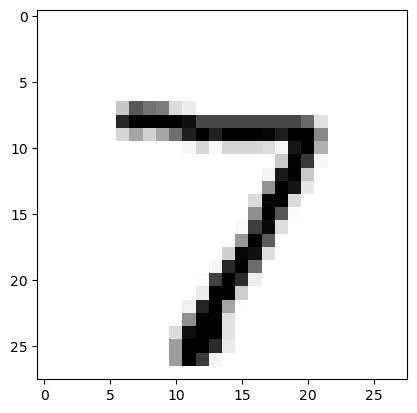

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
plt.imshow(test_images[0], cmap='Greys')

In [3]:
# Check our dataset
train_images.shape

(60000, 28, 28)

There are 60,000 images in the dataset. Each image has a height of 28 pixels and a width of 28 pixels, so they are 2D arrays. Each image has 1 color channel, indicating grayscale images. For convolutional neural networks (CNN) like LeNet-5, it's essential to maintain the spatial structure of the input images: CNNs are designed to exploit the 2D structure of images by using convolutional and pooling layers, which learn spatial hierarchies of features. The data's training variables are pixels which values range from 0 to 255, we divide them by 255 so they are normalized.

In [4]:
# Preprocess train and test

# Convert to floats in the range [0, 1] and normalize by dividing by 255
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# Check new shape
print(train_images.shape)
# Process labels
train_labels = to_categorical(train_labels) # same as OneHotEncoder
test_labels = to_categorical(test_labels)


(60000, 28, 28, 1)


Now, we create the model, using Sequential() which will create a network made of sequential layers of neurons. For each layer, we follow the description given above. This CNN architecture consists of alternating convolutional and pooling layers for feature extraction, followed by fully connected layers for classification. The ReLU activation function is used throughout the network, except for the output layer where softmax is used for multi-class classification.

In [5]:
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(), # flattens the input feature maps into a 1D array, preparing them for the fully connected layers
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

# Show a summary of the model with all the parameters (weights) to train
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               

For compiling the model, we choose adam as an optimizer during training as it is known for its efficiency and adaptability. The objective is indeed to minimize the loss function: if it is reduced to an acceptable level, the model has learned the function mapping input to output. The loss function to use during training is the categorical crossentropy as we are doing classification with more than 2 classes (the classes are 0 to 9, the digits). We will evaluate the model with accuracy as we are in a classification problem. 

We then fit the model with 20 epochs first (iterations over the entire training dataset), which we can increase later if needed. IT means that 20 times pass the entire training dataset. We use a batch size of 128 (128 training examples per iteration). We will pass the input on each iteration in batches of 128 samples. It affects both the speed and stability of the training process. We don't want low number to avoid too much noise, we don't want too high to avoid because it can be limiting (memory). Finally, we evaluate the model on the test dataset and print the loss and accuracy to assess how well the model generalizes to unseen data.

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)



Epoch 1/20


469/469 [==============================] - 3s 5ms/step - loss: 0.3723 - accuracy: 0.8906 - val_loss: 0.1267 - val_accuracy: 0.9600
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1091 - accuracy: 0.9667 - val_loss: 0.0726 - val_accuracy: 0.9766
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0765 - accuracy: 0.9769 - val_loss: 0.0520 - val_accuracy: 0.9836
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0503 - val_accuracy: 0.9832
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.0434 - val_accuracy: 0.9844
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.0403 - val_accuracy: 0.9869
Epo

In [7]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

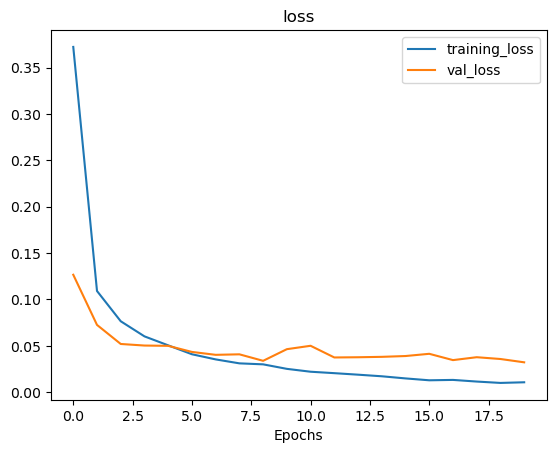

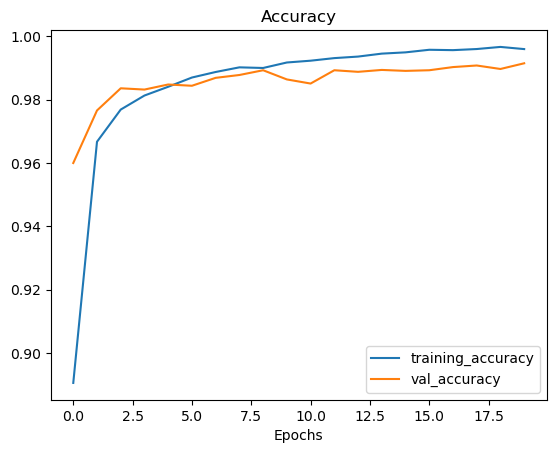

In [8]:
plot_loss_curves(history)

We get a final loss of 0.03 which is very low suggesting that the model predicts really well compared to the true labels, and a final accuracy of 99.15%, which is quite high, suggesting that the model learnt well from the train and performs well on the test set. Both training and validation loss decrease over epochs, while accuracy increases so model is learning effectively without significant signs of overfitting (both curves are following each other and converging). 